In [1]:
import numpy as np
import pandas as pd
import os
import glob
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM

/Users/ajaysingh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Pre-processing Review data

In [2]:
# Get the current working directory
working_dir=os.getcwd()

In [3]:
# Get the positive reviews in a list
path_pos = working_dir+'/train/pos' # use your path
allFiles_pos = glob.glob(path_pos + "/*.txt")
list_final_pos = []
for file in allFiles_pos:
    temp_pos=pd.read_table(file, header=None)
    list_pos=[]
    for r in temp_pos[0]:
        list_pos.append(r)
    list_pos=''.join(list_pos)
    list_final_pos.append(list_pos)  
    
# Get the negative reviews in a list
path_neg = working_dir+'/train/neg' # use your path
allFiles_neg = glob.glob(path_neg + "/*.txt")
list_final_neg = []
for file in allFiles_neg:
    temp_neg=pd.read_table(file, header=None)
    list_neg=[]
    for r in temp_neg[0]:
        list_neg.append(r)
    list_neg=''.join(list_neg)
    list_final_neg.append(list_neg)  

# Combine the lists
list_final = list_final_pos + list_final_neg

In [4]:
# define the labels
labels=[]
for i in range(0,25000):
    if i<12500:
        labels.append(1)
    else:
        labels.append(0)

In [19]:
'''
Clean each document by removing unnecesary characters and splitting by space.
'''
def clean_document(doco):
#     punctuation = string.punctuation + '\n\n';
#     punc_replace = ''.join([' ' for s in punctuation]);
# #     print(punc_replace)
#     doco_clean = doco.replace('-', ' ');
#     doco_alphas = re.sub(r'\W +', '', doco_clean)
#     trans_table = str.maketrans(punctuation, punc_replace);
#     doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')]);
    doco_clean = doco.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];
    
    return doco_clean;

review_cleans = [clean_document(doc) for doc in list_final];
sentences = [' '.join(r) for r in review_cleans]

print('Before Cleaning: ', list_final[10])
print('After Cleaning: ', sentences[10])

Before Cleaning:  Aileen Gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. She has a lovely scene with Roshan Seth in a restaurant. There's more information on her website at >Having stated my personal interest in the film, I have to say that I think it is a beautiful movie - moving, funny and beautifully filmed.
After Cleaning:  aileen gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. she has a lovely scene with roshan seth in a restaurant. there's more information on her website at >having stated my personal interest in the film, i have to say that i think it is a beautiful movie - moving, funny and beautifully filmed.


In [21]:
# Prepare Tokenizer
t = Tokenizer()
t.fit_on_texts(sentences)
vocab_size = len(t.word_index) + 1
print('Vocabulary Size: ', vocab_size)

# integer encode the documents
encoded_docs = t.texts_to_sequences(sentences)
print('\nText before Sequence Encoding: ', sentences[10])
print('Text after Sequence Encoding: ', encoded_docs[10])

# pad documents to a max length of 4 words
max_length = len(max(encoded_docs))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post') 
print('\nBefore Padding: ', encoded_docs[10])
print('After Padding: ', padded_docs[10])

Vocabulary Size:  88524

Text before Sequence Encoding:  aileen gonsalves, my girlfriend, is in this film playing a secretary at the main character's bank. she has a lovely scene with roshan seth in a restaurant. there's more information on her website at >having stated my personal interest in the film, i have to say that i think it is a beautiful movie - moving, funny and beautifully filmed.
Text after Sequence Encoding:  [18487, 51994, 58, 976, 6, 8, 11, 19, 393, 3, 3381, 30, 1, 290, 1745, 1974, 57, 45, 3, 1330, 133, 16, 20587, 7798, 8, 3, 3730, 222, 50, 1613, 20, 38, 3893, 30, 257, 3415, 58, 965, 599, 8, 1, 19, 10, 25, 5, 132, 12, 10, 101, 9, 6, 3, 304, 17, 724, 161, 2, 1289, 814]

Before Padding:  [18487, 51994, 58, 976, 6, 8, 11, 19, 393, 3, 3381, 30, 1, 290, 1745, 1974, 57, 45, 3, 1330, 133, 16, 20587, 7798, 8, 3, 3730, 222, 50, 1613, 20, 38, 3893, 30, 257, 3415, 58, 965, 599, 8, 1, 19, 10, 25, 5, 132, 12, 10, 101, 9, 6, 3, 304, 17, 724, 161, 2, 1289, 814]
After Padding:  [18487 

In [6]:
# Use pre-trained Glove word embeddings
embeddings_index = dict()
f = open('glove.6B.300d.txt') 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [7]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector# create a weight matrix for words in training docs

In [22]:
# Define independent and dependent variables
X = np.array(padded_docs)
y = np.array(labels)
# Split the data into training set and validation set
X_train,X_val,y_train,y_val= train_test_split(X,y,test_size=0.2,random_state=13)

In [28]:
# define LSTM model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(60))
model.add(Dropout(0.25))
# model.add(Flatten())
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [29]:
optimizer = Adam(lr=0.0001)
# compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [30]:
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 212, 300)          26557200  
_________________________________________________________________
lstm_4 (LSTM)                (None, 60)                86640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 26,647,561
Trainable params: 90,361
Non-trainable params: 26,557,200
___________________________________________________________

In [31]:
# Train the model
batch_size = 128
epochs = 15
lstm_model = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, verbose= 1, validation_data=(X_val,y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
20000/20000 [==============================] - 61s 3ms/step - loss: 0.6932 - acc: 0.5092 - val_loss: 0.6885 - val_acc: 0.5458
Epoch 2/15
20000/20000 [==============================] - 60s 3ms/step - loss: 0.6820 - acc: 0.5417 - val_loss: 0.6595 - val_acc: 0.5918
Epoch 3/15
20000/20000 [==============================] - 59s 3ms/step - loss: 0.6423 - acc: 0.6185 - val_loss: 0.6309 - val_acc: 0.6432
Epoch 4/15
20000/20000 [==============================] - 59s 3ms/step - loss: 0.6143 - acc: 0.6687 - val_loss: 0.5730 - val_acc: 0.7648
Epoch 5/15
20000/20000 [==============================] - 60s 3ms/step - loss: 0.5079 - acc: 0.7815 - val_loss: 0.4799 - val_acc: 0.7958
Epoch 6/15
20000/20000 [==============================] - 59s 3ms/step - loss: 0.4664 - acc: 0.7989 - val_loss: 0.4524 - val_acc: 0.8034
Epoch 7/15
20000/20000 [==============================] - 59s 3ms/step - loss: 0.4400 - acc: 0.8121 - val_loss: 0.4308 - val_acc:

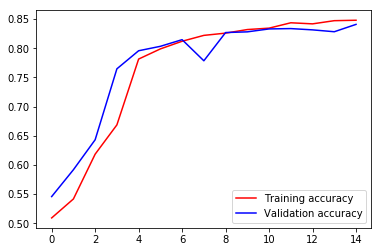

In [32]:
# Gives a list of accuracies
accuracy= lstm_model.history['acc']
val_accuracy = lstm_model.history['val_acc']
loss = lstm_model.history['loss']
val_loss = lstm_model.history['val_loss']

# Define x-axis
epoch=range(len(accuracy))
# Plot
plt.plot(epoch, accuracy, 'b', label='Training accuracy', color='r')
plt.plot(epoch, val_accuracy, 'b', label='Validation accuracy')
plt.legend()

# Test

In [55]:
# Get the positive reviews in a list
path_pos = working_dir+'/test/pos' # use your path
allFiles_pos = glob.glob(path_pos + "/*.txt")
test_list_final_pos = []
for file in allFiles_pos:
    temp_pos=pd.read_table(file, header=None)
    list_pos=[]
    for r in temp_pos[0]:
        list_pos.append(r)
    list_pos=''.join(list_pos)
    test_list_final_pos.append(list_pos)  
    
# Get the negative reviews in a list
path_neg = working_dir+'/test/neg' # use your path
allFiles_neg = glob.glob(path_neg + "/*.txt")
test_list_final_neg = []
for file in allFiles_neg:
    temp_neg=pd.read_table(file, header=None)
    list_neg=[]
    for r in temp_neg[0]:
        list_neg.append(r)
    list_neg=''.join(list_neg)
    test_list_final_neg.append(list_neg)  

# Combine the lists
test_list_final = test_list_final_pos + test_list_final_neg

In [57]:
len(test_list_final)

25000

In [58]:
len(labels)

25000

In [59]:
test_review_cleans = [clean_document(doc) for doc in test_list_final];
test_sentences = [' '.join(r) for r in test_review_cleans]

t.fit_on_texts(test_sentences)

In [60]:
test_encoded_docs = t.texts_to_sequences(test_sentences)


# pad documents to a max length of 4 words
max_length = len(max(test_encoded_docs))
test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_length, padding='post') 

In [63]:
model.evaluate(test_padded_docs,labels)

AttributeError: 'History' object has no attribute 'evaluate'

In [62]:
model.history

{'acc': [0.5634,
  0.62395,
  0.548,
  0.6624,
  0.6303,
  0.7314,
  0.79115,
  0.8084,
  0.82905,
  0.844,
  0.85315,
  0.8618,
  0.86905,
  0.8739,
  0.87895,
  0.88465,
  0.89145,
  0.89275,
  0.89935,
  0.905],
 'loss': [0.6766251764297485,
  0.6576078092575073,
  0.6802116195678711,
  0.6283672192573547,
  0.6430201340198517,
  0.5795192264556884,
  0.5031528396606445,
  0.46863952732086184,
  0.42699192018508914,
  0.37339579372406007,
  0.34702622203826905,
  0.3311570214748383,
  0.3183390146255493,
  0.3058153173208237,
  0.29738404808044433,
  0.28765466237068177,
  0.2741039462566376,
  0.2648162150144577,
  0.2554270729541779,
  0.24452546892166138],
 'val_acc': [0.6734000007629395,
  0.6451999995231629,
  0.633200000667572,
  0.6941999994277954,
  0.6931999997138977,
  0.7729999992370605,
  0.7512000001907349,
  0.8201999999046325,
  0.830600000667572,
  0.8379999994277955,
  0.8473999996185303,
  0.8534,
  0.8575999998092652,
  0.8571999996185303,
  0.8585999992370605,
  